# Training a Neural Network for credit card fraud detection

This notebook attempts to train a reasonably simple feed-forward neural network to classify famously imbalanced Kaggle dataset about fraudulent credit card transactions. See [the original dataset](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud).

The minority category (fraudulent transactions – treated as positive label) consist only about 0.17% of the data. The goal here is to classify transactions as either genuine or fraudulent with as high precision and recall as possible.

We have decided to try to do so with forward-feed deep neural network. The approach here is:
* basic inspection of the data,
* oversampling,
* feature engineering,
* training one neural network to see whether the design reasonably classifies the data,
* running GridSearchCV over slighlty different shapes of the network to find the best design.

**Let's start with library imports.**

In [1]:
"""NN for a Credit Card Data identification of fraudelant transactions."""
# skorch is an excellent library integrating pytorch into sklearn's API
!pip install skorch
# standard libraries
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import warnings
# the data itself is not large so dask is used only to speed up GridSearch
# over several networks
from dask.distributed import Client
from dask_cuda import LocalCUDACluster
from joblib import parallel_backend
# oversampling is used to partially address the imbalance
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot as plt
# things used from sklearn and skorch
from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer, \
    classification_report, roc_curve, roc_auc_score, precision_recall_curve, \
    precision_score, recall_score, average_precision_score
from sklearn.model_selection import train_test_split, StratifiedKFold, \
    GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from skorch import NeuralNetBinaryClassifier
from skorch.callbacks import EarlyStopping
# and classical PyTorch imports
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
# filter out warning about Future versions
warnings.filterwarnings(action='ignore', category=FutureWarning)
# setting a random state to replicate some randomised results (train-test splits)
rnd = np.random.RandomState(10)

# to get a speed up from distributed clusters using dask on network training
# during GridSearchCV
cluster = LocalCUDACluster()
c = Client(cluster)
c

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.3/239.3 kB 1.7 MB/s eta 0:00:00


/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current versio

Connection method: Cluster object,Cluster type: dask_cuda.LocalCUDACluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 2,Total memory: 29.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40057,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 2
Started: Just now,Total memory: 29.00 GiB
Comm: tcp://127.0.0.1:40477,Total threads: 1
Dashboard: http://127.0.0.1:44197/status,Memory: 14.50 GiB
Nanny: tcp://127.0.0.1:44205,


## Neural network model definition

In [2]:


class MyModel(nn.Module):
    """
    Instance of a Neural Network used for training.

    Args_:

        in_features: Number of input features.

        out_features: Number of output features.
        
        n_hidden: number of hidden layers
        
        hid_size_ratio: ratio between the size of the hidden layer
        and number of input features.
        
        dropout: dropout probability during training
    """

    def __init__(self, in_features, out_features, *,
                 n_hidden: int = 2, hid_size_ratio: float = 3,
                 dropout: float = 0.4):
        super().__init__()
        self.drop = nn.Dropout(dropout)
        self.in_features = in_features
        self.out_feat = out_features
        self.n_hidden = n_hidden

        # set an activation function
        self.activ = nn.LeakyReLU(negative_slope=0.1)

        # if there should be no hidden layers, go straight to output
        if n_hidden == 0:
            layers = [nn.Linear(in_features, out_features)]
        # for at least one hidden layer
        else:
            # calculate size of the hidden layer
            hid_size = int(hid_size_ratio*in_features)
            # create input layers
            layers = [nn.Linear(in_features, hid_size)]
            # create same sized hidden layers
            for _ in range(n_hidden-1):
                layers.append(nn.Linear(hid_size, hid_size))
            # add output layer
            layers.append(nn.Linear(hid_size, out_features))
        self.layers = nn.ModuleList(layers)

    def forward(self, X):
        """Forward propagation of data in the NN."""
        for layer in self.layers[:-1]:
            X = self.activ(layer(X))
            if self.training:
                X = self.drop(X)
        X = self.activ(self.layers[-1](X))

        if self.out_feat == 1:
            return X
        else:
            return torch.softmax(X, dim=1)

## Training loop definition

Even though usage of *skorch* library would allow us to skip this definition and use *scikit-learn*'s API, we are using this training loop just to fit the first neural network to ensure, that eveything works the way it's supposed to.

In [3]:
def train(model, optimiser,
          train_data,
          test_data,
          n_epochs=100, loss_fun=nn.MSELoss()):
    """
    NN training loop. Return is None, but optimises the NN.

    Args_:

        model: The NN (or other) model used for data fit.
        
        optimiser: Optimisation method for backward pass.
        
        train_data: Training set of data from DataLoader.
        
        test_data: Testing set of data from DataLoader..
        
        n_epochs: Number of iterations for the propagation.
        
        loss_fun: Loss function to minimise via back-propagation.

    Returns_:

        None.
        NN is optimised in the process, by adjusting the Arg "model".
    """
    for epoch in range(n_epochs+1):
        # train the neural network one batch at a time
        model.train()
        train_loss = 0
        for data, target in train_data:
            data, target = data.cuda(), target.cuda()
            pred_train = model(data)
            batch_train_loss = loss_fun(pred_train, target)

            train_loss += batch_train_loss.item() * data.size(0)

            optimiser.zero_grad()
            batch_train_loss.backward()
            optimiser.step()
        del data, target, pred_train

        model.eval()
        # validate for each epoch
        test_loss = 0
        with torch.no_grad():
            for data, target in test_data:
                data, target = data.cuda(), target.cuda()
                pred_test = model(data)
                batch_test_loss = loss_fun(pred_test, target)

                test_loss += batch_test_loss.item() * data.size(0)
        del data, target, pred_test

        # print epoch results
        if epoch < 20 or epoch % 10 == 0:
            print(f'Epoch {epoch}/{n_epochs};', ''*5,
                  f'    Train loss: {train_loss:.3f};', ''*5,
                  f'    Valid loss: {test_loss:.3f}')

        # setup for an early stop
        if epoch == 0:
            last_5 = torch.full((5, 1), float(test_loss)).cuda()
        else:
            last_5[epoch % 5] = test_loss
        # break if test loss not improving
        if epoch > 5 and test_loss > last_5.mean()*0.999:
            print(f'\nBreak on epoch{epoch}/{n_epochs}')
            break

# First look at data

Let's import the data, immediately drop duplicate cases and look at data info.

In [4]:
# import
data_in = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv',
                      index_col=0)
data_in = data_in.drop_duplicates()
data_in.info()

<class 'pandas.core.frame.DataFrame'>
Index: 275663 entries, 0.0 to 172792.0
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      275663 non-null  float64
 1   V2      275663 non-null  float64
 2   V3      275663 non-null  float64
 3   V4      275663 non-null  float64
 4   V5      275663 non-null  float64
 5   V6      275663 non-null  float64
 6   V7      275663 non-null  float64
 7   V8      275663 non-null  float64
 8   V9      275663 non-null  float64
 9   V10     275663 non-null  float64
 10  V11     275663 non-null  float64
 11  V12     275663 non-null  float64
 12  V13     275663 non-null  float64
 13  V14     275663 non-null  float64
 14  V15     275663 non-null  float64
 15  V16     275663 non-null  float64
 16  V17     275663 non-null  float64
 17  V18     275663 non-null  float64
 18  V19     275663 non-null  float64
 19  V20     275663 non-null  float64
 20  V21     275663 non-null  float64
 21  V22     275

All values appear to be numeric, column "Class" is the target label (0 for genuine, 1 for fraudulent transactions) and is the only integer column.

Checking the size of the DataFrame with the number of non-null values shows that we have no missing values.
The reason is that this is highly processed, very nicely prepared dataset. The individual features are a result of a PCA transform from a confidential data, that could not be pulished.

In [5]:
data_in.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
V1,275663.0,-0.037460,1.952522,-56.407510,-0.941105,-0.059659,1.294471,2.454930
V2,275663.0,-0.002430,1.667260,-72.715728,-0.614040,0.070249,0.819067,22.057729
V3,275663.0,0.025520,1.507538,-48.325589,-0.843168,0.200736,1.048461,9.382558
V4,275663.0,-0.004359,1.424323,-5.683171,-0.862847,-0.035098,0.753943,16.875344
V5,275663.0,-0.010660,1.378117,-113.743307,-0.700192,-0.060556,0.604521,34.801666
V6,275663.0,-0.014206,1.313213,-26.160506,-0.765861,-0.270931,0.387704,73.301626
V7,275663.0,0.008586,1.240348,-43.557242,-0.552047,0.044848,0.583885,120.589494
V8,275663.0,-0.005698,1.191596,-73.216718,-0.209618,0.022980,0.322319,20.007208
V9,275663.0,-0.012363,1.100108,-13.434066,-0.659904,-0.064724,0.593098,15.594995
V10,275663.0,0.003114,1.087025,-24.588262,-0.538968,-0.091752,0.470702,23.745136


Only confirming what we have seen before. Majority of features has zero mean, but varying deviations, let's normalise the data using StandardScaler().

We will create a separate dataset for testing right away to maintain as clean and information-leak-proof models as we can.
The way the data is provided is a little problematic in this regard as we do not know, whether the data we are using as train data were involved in the original PCA.

In [6]:
# =============================================================================
# creation of test train data
# =============================================================================
# not balancing categories in the train set
X, y = data_in[data_in.columns[:-1]], data_in[data_in.columns[-1]]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8,
                                                    shuffle=True,
                                                    stratify=y,
                                                    random_state=rnd)

# rescaling the data
scaler = StandardScaler().set_output(transform="pandas")
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Let's oversample our minority class right away using SMOTE.

In [7]:
# oversampling with about 5:1 samples
samp_strat = 0.01
smote = SMOTE(sampling_strategy=samp_strat,
              k_neighbors=5,
              random_state=rnd)
X_train, y_train = smote.fit_resample(X_train, y_train)

Let us inspect the data after normalisation and oversampling.

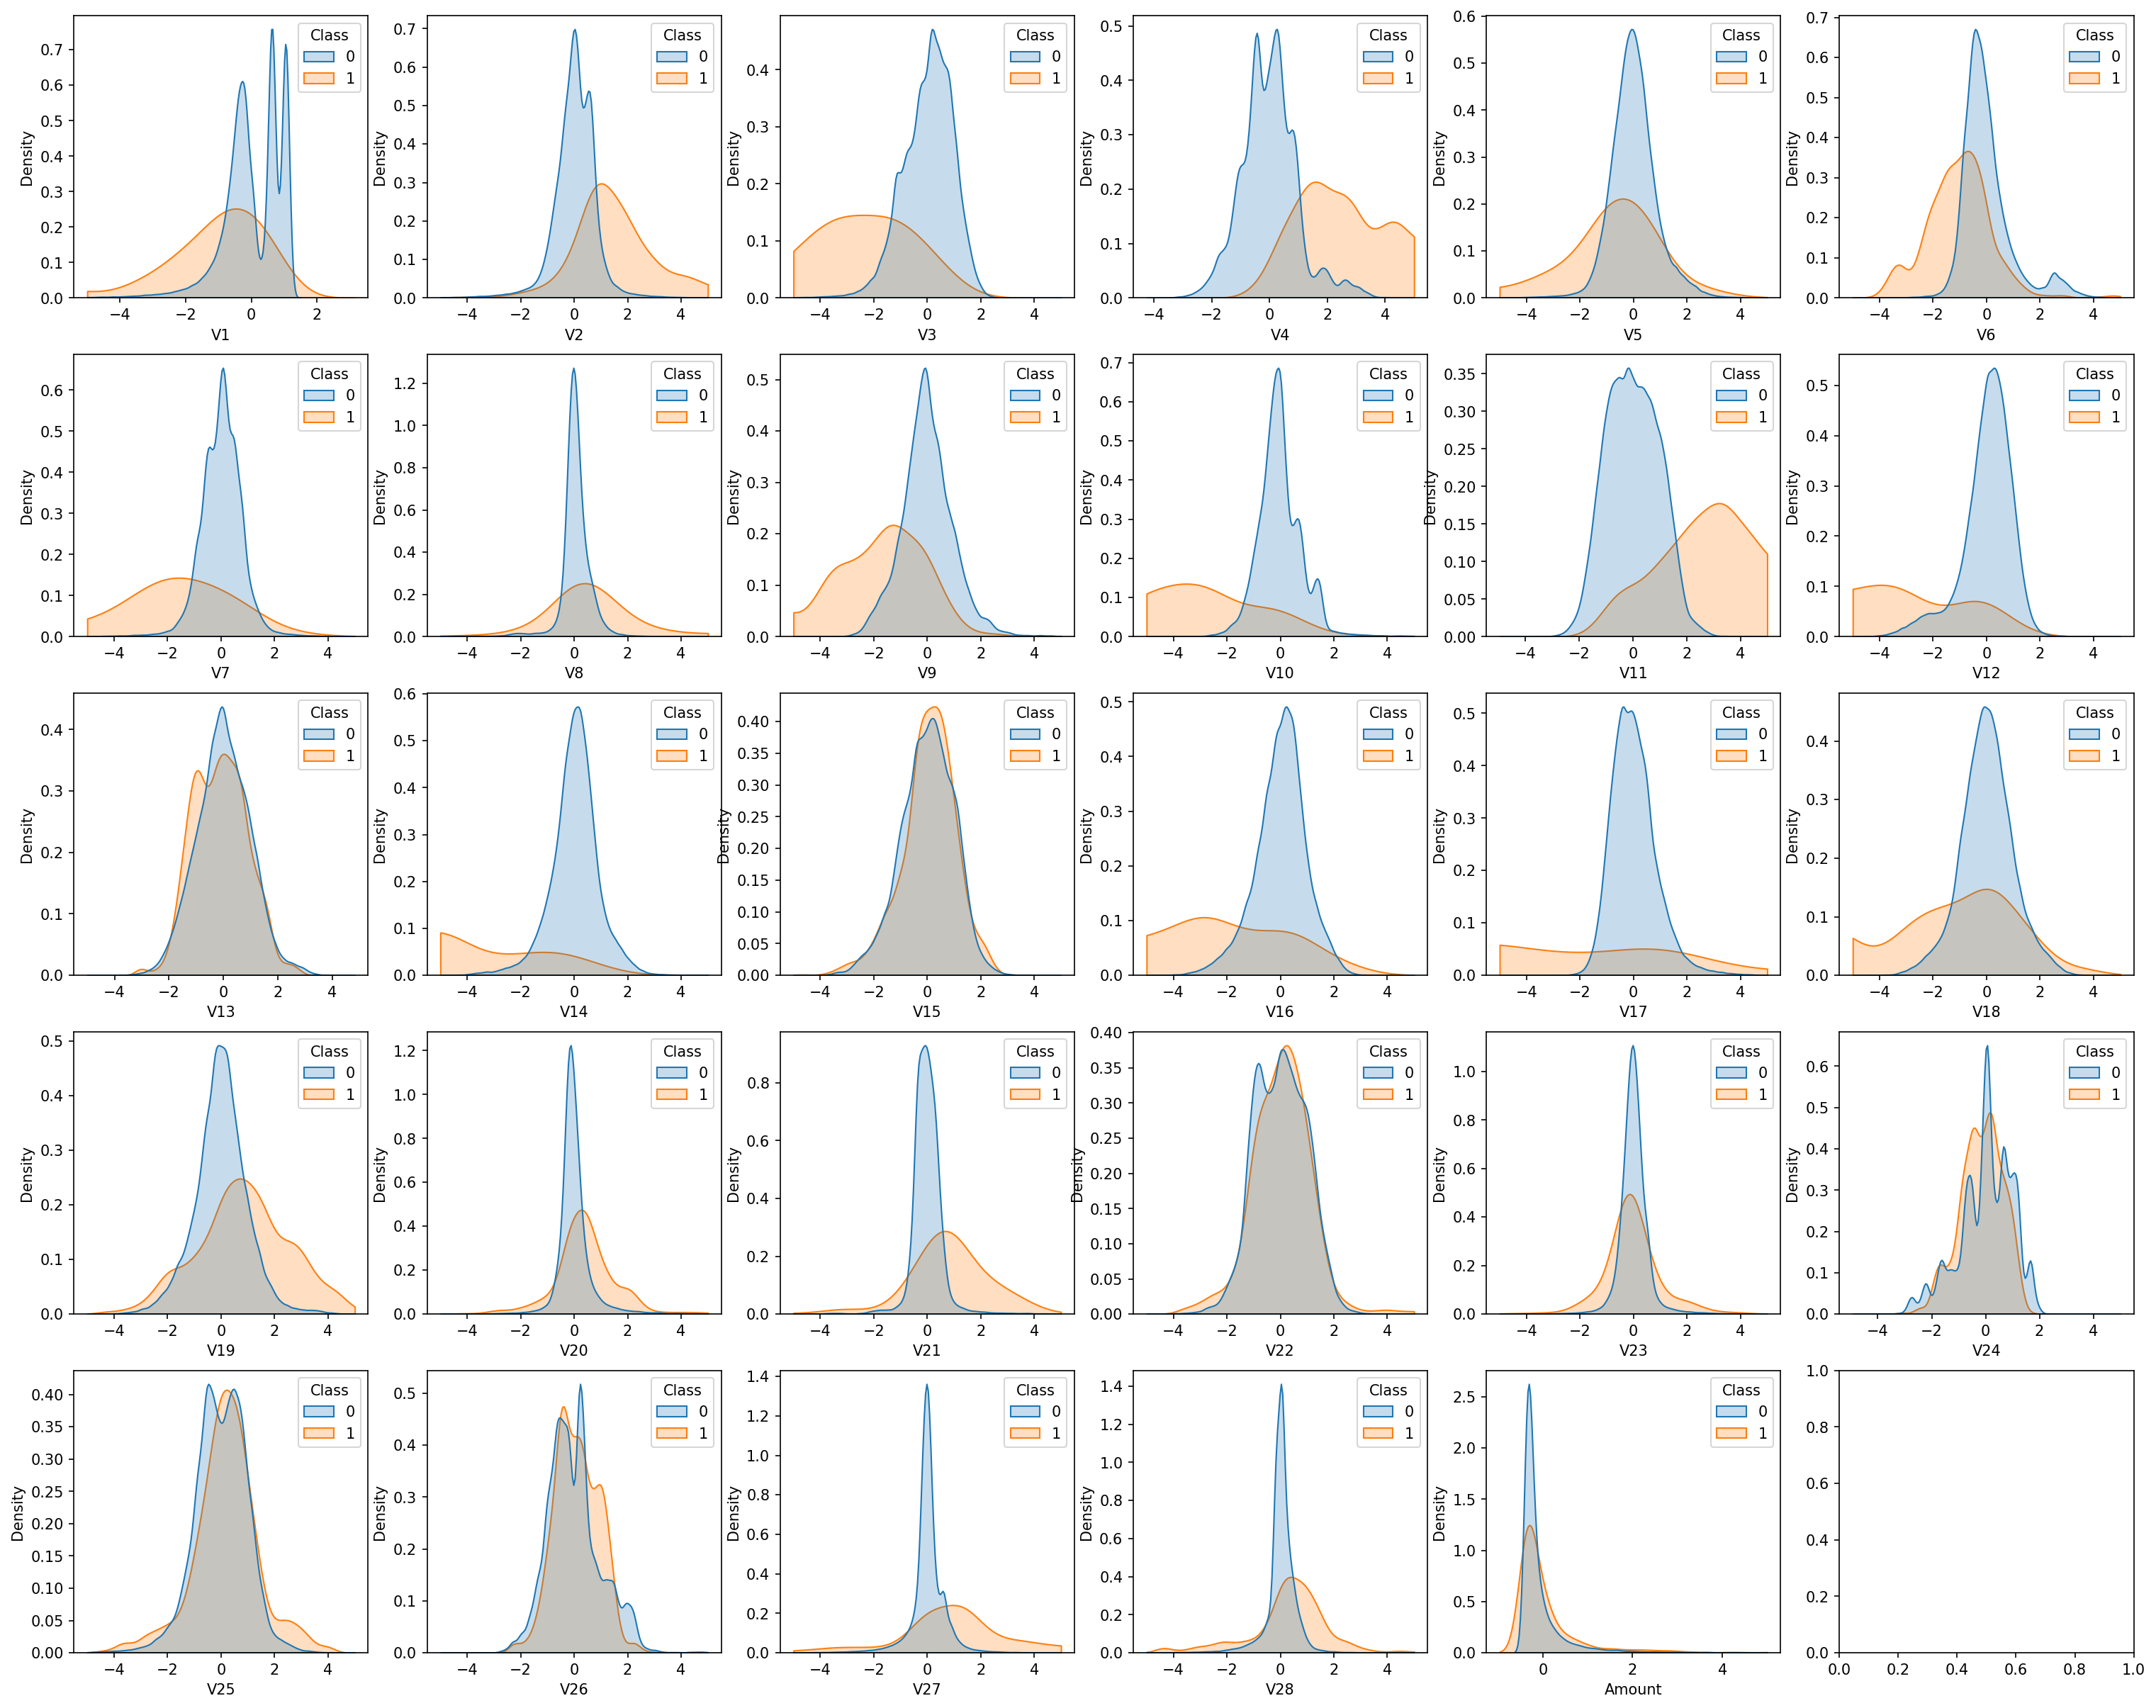

In [8]:
fig, axs = plt.subplots(5, 6, figsize=(25, 20), dpi=150)
ax = axs.ravel()
df_plot = pd.concat([X_train, y_train], axis=1)
for i, feat in enumerate(X_train.columns):
    sns.kdeplot(df_plot, x=feat, hue='Class',
                ax=ax[i],
                common_norm=False, fill=True, clip=[-5, 5])
plt.show()
plt.close(fig)
del df_plot, i, feat

Some of the features appear to be more informative about the fraudulant nature of the transactions than others. We can either further inspect the features here (e.g. create a smaller, balanced dataset with undersampled negative class and ispect correlations between different features, BUT this dataset is result of a PCA – features that correlated in the original data were already reduced into the same dimensions).

So let us simply drop couple of features (even though it is not necessary, the training time does not differ by much). Visual inspection suggests, that V13, V15, V22 and V25 are very similar for both classes, let's drop 3 features than.

In [9]:
drop_feat = 3

feature_selection = SelectKBest(k=X_train.shape[1] - drop_feat
                                ).set_output(transform="pandas")
X_train = feature_selection.fit_transform(X_train, y_train)
X_test = feature_selection.transform(X_test)

X_train.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V23',
       'V24', 'V25', 'V26', 'V27', 'V28'],
      dtype='object')

**NOTE:** The features missing are V13, V15 and V22.

**NOTE:** Should the model we train be deployed, all of these processess would have to be included into a pipeline, we could've created a simple transformer, yet the commenting throughout the code is more illustrative.

# Training first neural network

It is time to load our data to PyTorch and train the first draft of the Neural Network with the default structure (2 hidden layers, number of hidden features is twice the number of input features).

In [10]:

X_train = torch.tensor(X_train.to_numpy().copy(), dtype=torch.float)
X_test = torch.tensor(X_test.to_numpy().copy(), dtype=torch.float)
y_train = torch.tensor(y_train.to_numpy().copy(), dtype=torch.float
                       ).unsqueeze(1)
y_test = torch.tensor(y_test.to_numpy().copy(), dtype=torch.float
                      ).unsqueeze(1)


train_data = TensorDataset(X_train, y_train)
train_data = DataLoader(train_data, batch_size=4096, shuffle=True)
test_data = TensorDataset(X_test, y_test)
test_data = DataLoader(test_data, batch_size=4096, shuffle=True)


modelNN = MyModel(X_train.shape[1], 1).cuda()
# gradient descent optimiser
Adam_optimiser = optim.Adam(modelNN.parameters(), lr=1e-3)
# train data is sampled about 100:1, but let's penalise that harshly
weight = torch.tensor((3*1/samp_strat, ), dtype=torch.float).cuda()
loss = nn.BCEWithLogitsLoss(pos_weight=weight)

train(modelNN, Adam_optimiser,
      train_data,
      test_data,
      n_epochs=30, loss_fun=loss)

# =============================================================================

Epoch 0/30;      Train loss: 269103.026;      Valid loss: 41265.465
Epoch 1/30;      Train loss: 208855.101;      Valid loss: 39672.109
Epoch 2/30;      Train loss: 190816.933;      Valid loss: 35394.745
Epoch 3/30;      Train loss: 170715.460;      Valid loss: 28196.590
Epoch 4/30;      Train loss: 144871.138;      Valid loss: 21861.321
Epoch 5/30;      Train loss: 122580.027;      Valid loss: 16543.047
Epoch 6/30;      Train loss: 109224.409;      Valid loss: 14130.113
Epoch 7/30;      Train loss: 101241.155;      Valid loss: 14126.020
Epoch 8/30;      Train loss: 95612.171;      Valid loss: 12044.413
Epoch 9/30;      Train loss: 88609.426;      Valid loss: 12060.568
Epoch 10/30;      Train loss: 87111.718;      Valid loss: 11930.878
Epoch 11/30;      Train loss: 81544.175;      Valid loss: 11014.054
Epoch 12/30;      Train loss: 77614.916;      Valid loss: 10557.338
Epoch 13/30;      Train loss: 73699.934;      Valid loss: 10227.530
Epoch 14/30;      Train loss: 70959.312;      Vali

**NOTE:** Using test data as validation test during training leads to overestimation of the net performance. We should have created a separate validation dataset used during training. Nonetheless, this net is not meant to be used for final deployment, only to assess whether such network can capture the patterns in the data.

Let us look at the model performance then.

                 ROC threshold = 1.2137610912322998
Accuracy on the test set: 98.295%
Class report:
                  precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     55038
         1.0       0.09      0.94      0.16        95

    accuracy                           0.98     55133
   macro avg       0.54      0.96      0.58     55133
weighted avg       1.00      0.98      0.99     55133

                 PRC threshold = 4.099116325378418
Accuracy on the test set: 99.824%
Class report:
                  precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     55038
         1.0       0.49      0.92      0.64        95

    accuracy                           1.00     55133
   macro avg       0.75      0.96      0.82     55133
weighted avg       1.00      1.00      1.00     55133



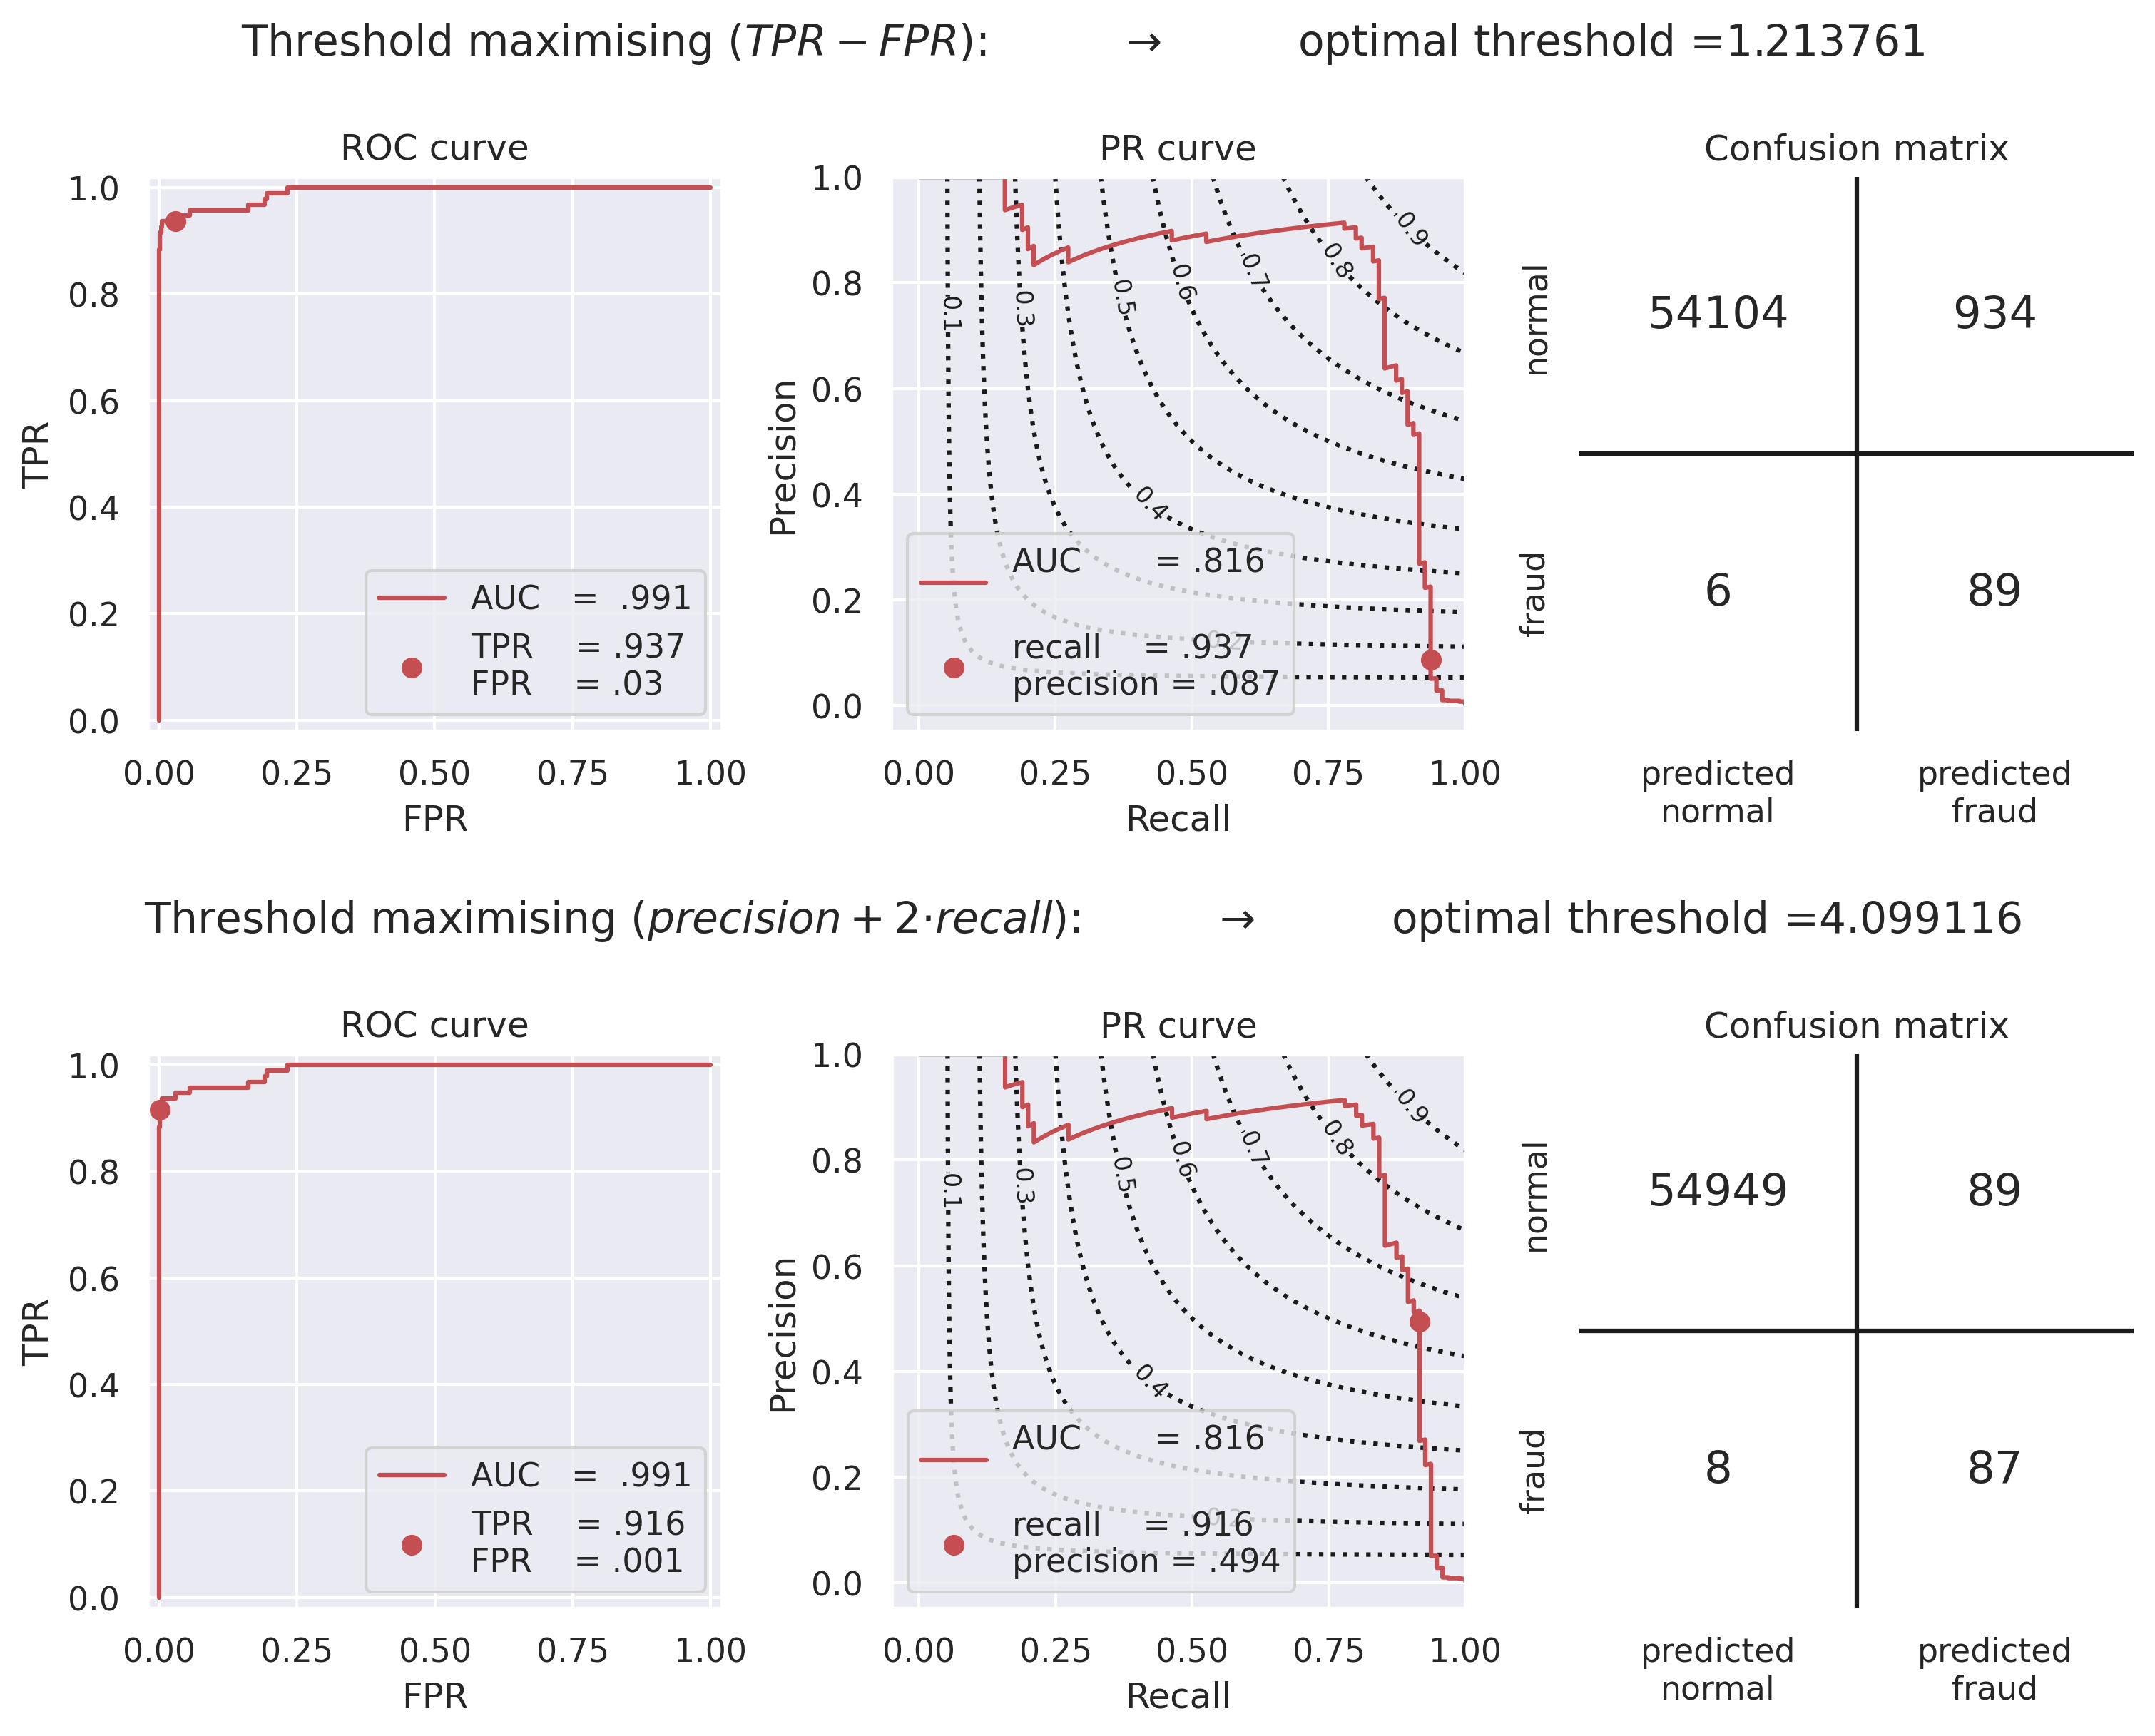

In [11]:
fig = plt.figure(layout='constrained', figsize=(10, 8), dpi=300)
subfigs = fig.subfigures(2, 1, hspace=0.05)

# =============================================================================
# finding optimal classifier threshold using train set (data leak prevention)
predicted_prob = (modelNN(X_train.cuda())).detach().cpu()
# for cell reruns, when y_train/test is already detached numpy array
if isinstance(y_train, torch.Tensor):
    y_train = y_train.squeeze(1).numpy()
    y_test = y_test.squeeze(1).numpy()

fpr, tpr, thresholds = roc_curve(y_train, predicted_prob)
optim_thresh = thresholds[np.argmax(tpr - fpr)]

sns.set_theme(style='darkgrid')

predicted_prob = (modelNN(X_test.cuda())).detach().cpu()


print(' ', '='*80, '\n', ' '*15, f'ROC threshold = {optim_thresh}\n', '='*80)
# Convert predictions to 0/1 labels
predicted_labels = predicted_prob.squeeze().ge(optim_thresh).int().numpy()

# Calculate accuracy on the test set
accuracy = accuracy_score(y_test, predicted_labels)
conf_matr = confusion_matrix(y_test, predicted_labels)
conf_matr = pd.DataFrame(conf_matr,
                         columns=['predicted\nnormal', 'predicted\nfraud'],
                         index=['normal', 'fraud'])
clas_rep = classification_report(y_test, predicted_labels)
print(f'Accuracy on the test set: {accuracy * 100:.3f}%\n'
      f'Class report:\n    {clas_rep}')

# ROC and PRC curves

axs1 = subfigs[0].subplots(1, 3)
subfigs[0].suptitle('Threshold maximising $(TPR - FPR)$:' +
                    ' '*10 + '→' + ' '*10 +
                    'optimal threshold =' + f'{optim_thresh:.6f}\n'.strip('0'))
axs1[0].set_title('ROC curve')
# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, predicted_prob)
auc = roc_auc_score(y_test, predicted_prob)
axs1[0].plot(fpr, tpr, 'r', label='AUC   =  '+f'{auc:.3f}'.strip('0'))
# optim_thresh
thr_idx = np.argmin(np.abs(thresholds - optim_thresh))
axs1[0].plot(fpr[thr_idx], tpr[thr_idx], 'ro', markersize=6,
             label='TPR    = '+f'{tpr[thr_idx]:.3f}\n'.strip('0') +
                   'FPR    = '+f'{fpr[thr_idx]:.3f}'.strip('0')
             )
# visuals
axs1[0].legend(loc='lower right')
axs1[0].set_xlabel('FPR')
axs1[0].set_ylabel('TPR')

# precision recall curve
# f1 score contours
array_0_1 = np.linspace(0.01, 1, 100)
f1_grid = np.empty((100, 100))
for i, a in enumerate(array_0_1):
    for ii, b in enumerate(array_0_1):
        f1_grid[i, ii] = 2*a*b/(a+b)
grid = np.meshgrid(array_0_1, array_0_1)
f1_score = axs1[1].contour(grid[0], grid[1], f1_grid,
                           levels=np.arange(0, 1, 0.1),
                           linestyles='dotted', colors='k')
axs1[1].clabel(f1_score, inline=True, fontsize=8)
del array_0_1, i, a, ii, b, f1_grid
# PRC
axs1[1].set_title('PR curve')
prec, rec, thresholds = precision_recall_curve(y_test, predicted_prob)
auc = average_precision_score(y_test, predicted_prob)
axs1[1].plot(rec, prec, 'r',
             label='AUC       = '+f'{auc:.3f}\n'.strip('0'))
# optim thresh
thr_idx = np.argmin(np.abs(thresholds - optim_thresh))
axs1[1].plot(rec[thr_idx], prec[thr_idx], 'ro', markersize=6,
             label='recall    = '+f'{rec[thr_idx]:.3f}\n'.strip('0') +
                   'precision = '+f'{prec[thr_idx]:.3f}'.strip('0'))
# visuals
axs1[1].set_xlabel('Recall')
axs1[1].set_ylabel('Precision')
axs1[1].legend(loc='lower left')

# plot confusion matrix
axs1[2].set_title('Confusion matrix')
sns.heatmap(conf_matr, cmap=['w'],
            ax=axs1[2], cbar=False, square=True,
            annot=True, fmt='.0f', annot_kws={'fontsize': 15})
axs1[2].vlines(1, 0, 2, 'k')
axs1[2].hlines(1, 0, 2, 'k')


for ax in axs1[0:1].flat:
    ax.set_xlim(-0.02, 1.02)
    ax.set_ylim(-0.02, 1.02)


# =============================================================================
# optimal threshold from PRC
# =============================================================================
# finding optimal classifier threshold using train set (data leak prevention)
predicted_prob = (modelNN(X_train.cuda())).detach().cpu()
coef = 2
prec, rec, thresholds = precision_recall_curve(y_train, predicted_prob)
optim_thresh = thresholds[np.argmax(prec + coef*rec)]

sns.set_theme(style='darkgrid')

predicted_prob = (modelNN(X_test.cuda())).detach().cpu()


print(' ', '='*80, '\n', ' '*15, f'PRC threshold = {optim_thresh}\n', '='*80)
# Convert predictions to 0/1 labels
predicted_labels = predicted_prob.squeeze().ge(optim_thresh).int().numpy()

# Calculate accuracy on the test set
accuracy = accuracy_score(y_test, predicted_labels)
conf_matr = confusion_matrix(y_test, predicted_labels)
conf_matr = pd.DataFrame(conf_matr,
                         columns=['predicted\nnormal', 'predicted\nfraud'],
                         index=['normal', 'fraud'])
clas_rep = classification_report(y_test, predicted_labels)
print(f'Accuracy on the test set: {accuracy * 100:.3f}%\n'
      f'Class report:\n    {clas_rep}')

# ROC and PRC curves
axs2 = subfigs[1].subplots(1, 3)
subfigs[1].suptitle(f'Threshold maximising $(precision + {coef}⋅recall)$:' +
                    ' '*10 + '→' + ' '*10 +
                    'optimal threshold ='+f'{optim_thresh:.6f}\n'.strip('0'))
axs2[0].set_title('ROC curve')
# 2ROC curve
fpr, tpr, thresholds = roc_curve(y_test, predicted_prob)
auc = roc_auc_score(y_test, predicted_prob)
axs2[0].plot(fpr, tpr, 'r', label='AUC   =  '+f'{auc:.3f}'.strip('0'))
# optim_thresh
thr_idx = np.argmin(np.abs(thresholds - optim_thresh))
axs2[0].plot(fpr[thr_idx], tpr[thr_idx], 'ro', markersize=6,
             label='TPR    = '+f'{tpr[thr_idx]:.3f}\n'.strip('0') +
                   'FPR    = '+f'{fpr[thr_idx]:.3f}'.strip('0')
             )
# visuals
axs2[0].legend(loc='lower right')
axs2[0].set_xlabel('FPR')
axs2[0].set_ylabel('TPR')

# precision recall curve
# f1 score contours
array_0_1 = np.linspace(0.01, 1, 100)
f1_grid = np.empty((100, 100))
for i, a in enumerate(array_0_1):
    for ii, b in enumerate(array_0_1):
        f1_grid[i, ii] = 2*a*b/(a+b)
grid = np.meshgrid(array_0_1, array_0_1)
f1_score = axs2[1].contour(grid[0], grid[1], f1_grid,
                           levels=np.arange(0, 1, 0.1),
                           linestyles='dotted', colors='k')
axs2[1].clabel(f1_score, inline=True, fontsize=8)
del array_0_1, i, a, ii, b, f1_grid
# PRC
axs2[1].set_title('PR curve')
prec, rec, thresholds = precision_recall_curve(y_test, predicted_prob)
auc = average_precision_score(y_test, predicted_prob)
axs2[1].plot(rec, prec, 'r',
             label='AUC       = '+f'{auc:.3f}\n'.strip('0'))
# optim thresh
thr_idx = np.argmin(np.abs(thresholds - optim_thresh))
axs2[1].plot(rec[thr_idx], prec[thr_idx], 'ro', markersize=6,
             label='recall    = '+f'{rec[thr_idx]:.3f}\n'.strip('0') +
                   'precision = '+f'{prec[thr_idx]:.3f}'.strip('0'))
# visuals
axs2[1].set_xlabel('Recall')
axs2[1].set_ylabel('Precision')
axs2[1].legend(loc='lower left')

# plot confusion matrix
axs2[2].set_title('Confusion matrix')
sns.heatmap(conf_matr, cmap=['w'],
            ax=axs2[2], cbar=False, square=True,
            annot=True, fmt='.0f', annot_kws={'fontsize': 15})
axs2[2].vlines(1, 0, 2, 'k')
axs2[2].hlines(1, 0, 2, 'k')

for ax in axs2[0:1].flat:
    ax.set_xlim(-0.02, 1.02)
    ax.set_ylim(-0.02, 1.02)

# plt.tight_layout()
plt.show()
plt.close()

Inspecting accuracies does not have much sense here due to the imbalance in the dataset. Inspection of the confusion matrices, on the other hand, looks interesting. The classifier does not perform that bad.

Although, let us remind here, that the results are overflatuated because we have used testing dataset for validation. Nonetheless, it appears that this fairly simple network can capture the patterns in the data quite well.

# Looking for optimal network structure

Tweaking the network structure could improve the performance, let's look at different depths and sizes of the hidden layer using GridSearchCV.

In [12]:
# # # # Add GridSearchCV to find optimal Net Structure

# =============================================================================
# data pipeline
# =============================================================================
# not balancing categories in the test set
X, y = data_in[data_in.columns[:-1]], data_in[data_in.columns[-1]]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8,
                                                    shuffle=True,
                                                    stratify=y,
                                                    random_state=rnd)
# rescaling the data
scaler = StandardScaler().set_output(transform="pandas")
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# oversampling of about 10:1
smote = SMOTE(sampling_strategy=samp_strat, k_neighbors=5, random_state=rnd)
X_train, y_train = smote.fit_resample(X_train, y_train)

# casting to PyTorch tensors
X_train = torch.tensor(X_train.to_numpy().copy(), dtype=torch.float)
X_test = torch.tensor(X_test.to_numpy().copy(), dtype=torch.float)
y_train = torch.tensor(y_train.to_numpy().copy(), dtype=torch.float)
y_test = torch.tensor(y_test.to_numpy().copy(), dtype=torch.float)
# -----------------------------------------------------------------------------
# =============================================================================

# Skorch can wrap PyTorch's network in sklearn's estimator APIs
net = NeuralNetBinaryClassifier(
                                # model set-up
                                module=MyModel,
                                module__in_features=X_train.shape[1],
                                module__out_features=1,
                                # training setups
                                optimizer=optim.Adam,
                                criterion=nn.BCEWithLogitsLoss,
                                batch_size=1024,
                                callbacks=[EarlyStopping()],
                                device='cuda',
                                iterator_train__shuffle=True,
                                # how talkative the model should be
                                verbose=0,
                                # 'auto' for BCEWithLogitsLoss adds a sigmoid
                                # when calling predict() or pred_proba()
                                # so the output of the NN can be just a linear
                                # layer
                                predict_nonlinearity='auto')

# create folds for cross validation
sgkf = StratifiedKFold(shuffle=True)

# parameters to look through during grid search
weights = [torch.tensor((k*1/samp_strat, ), dtype=torch.float).cuda()
          for k in range(1,4)]
param_grid = {'module__n_hidden': [1, 2, 3],
              'module__hid_size_ratio': np.arange(0.5, 3.5, 0.5),
              'criterion__pos_weight': weights}


# area under precision-recall curve to be used as a scorer
def au_prc(net, X, y):
    y_proba = net.predict_proba(X)[:, 1]
    return average_precision_score(y, y_proba)


# create the GridSearch
search = GridSearchCV(net,
                      param_grid,
                      scoring=au_prc,
                      cv=sgkf,
                      n_jobs=-1,
                      refit=True,
                      return_train_score=True,
                      verbose=3
                      )

# fit using all parallel GPUs
with parallel_backend('dask'):
    search.fit(X_train, y_train)

# save the best results
best_NN = search.best_estimator_
best_params = search.best_params_
best_score = search.best_score_

Fitting 5 folds for each of 54 candidates, totalling 270 fits


/opt/conda/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 25.46 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


[CV 1/5] END criterion__pos_weight=tensor([100.], device='cuda:0'), module__hid_size_ratio=0.5, module__n_hidden=1;, score=(train=0.898, test=0.880) total time=  29.6s
[CV 2/5] END criterion__pos_weight=tensor([100.], device='cuda:0'), module__hid_size_ratio=0.5, module__n_hidden=1;, score=(train=0.896, test=0.882) total time=  31.5s
[CV 3/5] END criterion__pos_weight=tensor([100.], device='cuda:0'), module__hid_size_ratio=0.5, module__n_hidden=1;, score=(train=0.906, test=0.902) total time=  28.3s
[CV 4/5] END criterion__pos_weight=tensor([100.], device='cuda:0'), module__hid_size_ratio=0.5, module__n_hidden=1;, score=(train=0.908, test=0.906) total time=  29.2s
[CV 5/5] END criterion__pos_weight=tensor([100.], device='cuda:0'), module__hid_size_ratio=0.5, module__n_hidden=1;, score=(train=0.899, test=0.921) total time=  28.5s
[CV 2/5] END criterion__pos_weight=tensor([100.], device='cuda:0'), module__hid_size_ratio=0.5, module__n_hidden=2;, score=(train=0.907, test=0.886) total time=

What is our best model?

In [13]:
best_NN.module_

MyModel(
  (drop): Dropout(p=0.4, inplace=False)
  (activ): LeakyReLU(negative_slope=0.1)
  (layers): ModuleList(
    (0): Linear(in_features=29, out_features=72, bias=True)
    (1): Linear(in_features=72, out_features=72, bias=True)
    (2): Linear(in_features=72, out_features=1, bias=True)
  )
)

In [14]:
best_params

{'criterion__pos_weight': tensor([100.], device='cuda:0'),
 'module__hid_size_ratio': 2.5,
 'module__n_hidden': 2}

In [15]:
best_score

0.9464451708672416

## How does our model perform?

                 ROC threshold = 0.4001934230327606
Accuracy on the test set: 98.808%
Class report:
                  precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     55038
         1.0       0.11      0.85      0.20        95

    accuracy                           0.99     55133
   macro avg       0.56      0.92      0.60     55133
weighted avg       1.00      0.99      0.99     55133

                 PRC threshold = 0.9760034084320068
Accuracy on the test set: 99.781%
Class report:
                  precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     55038
         1.0       0.43      0.83      0.57        95

    accuracy                           1.00     55133
   macro avg       0.71      0.91      0.78     55133
weighted avg       1.00      1.00      1.00     55133



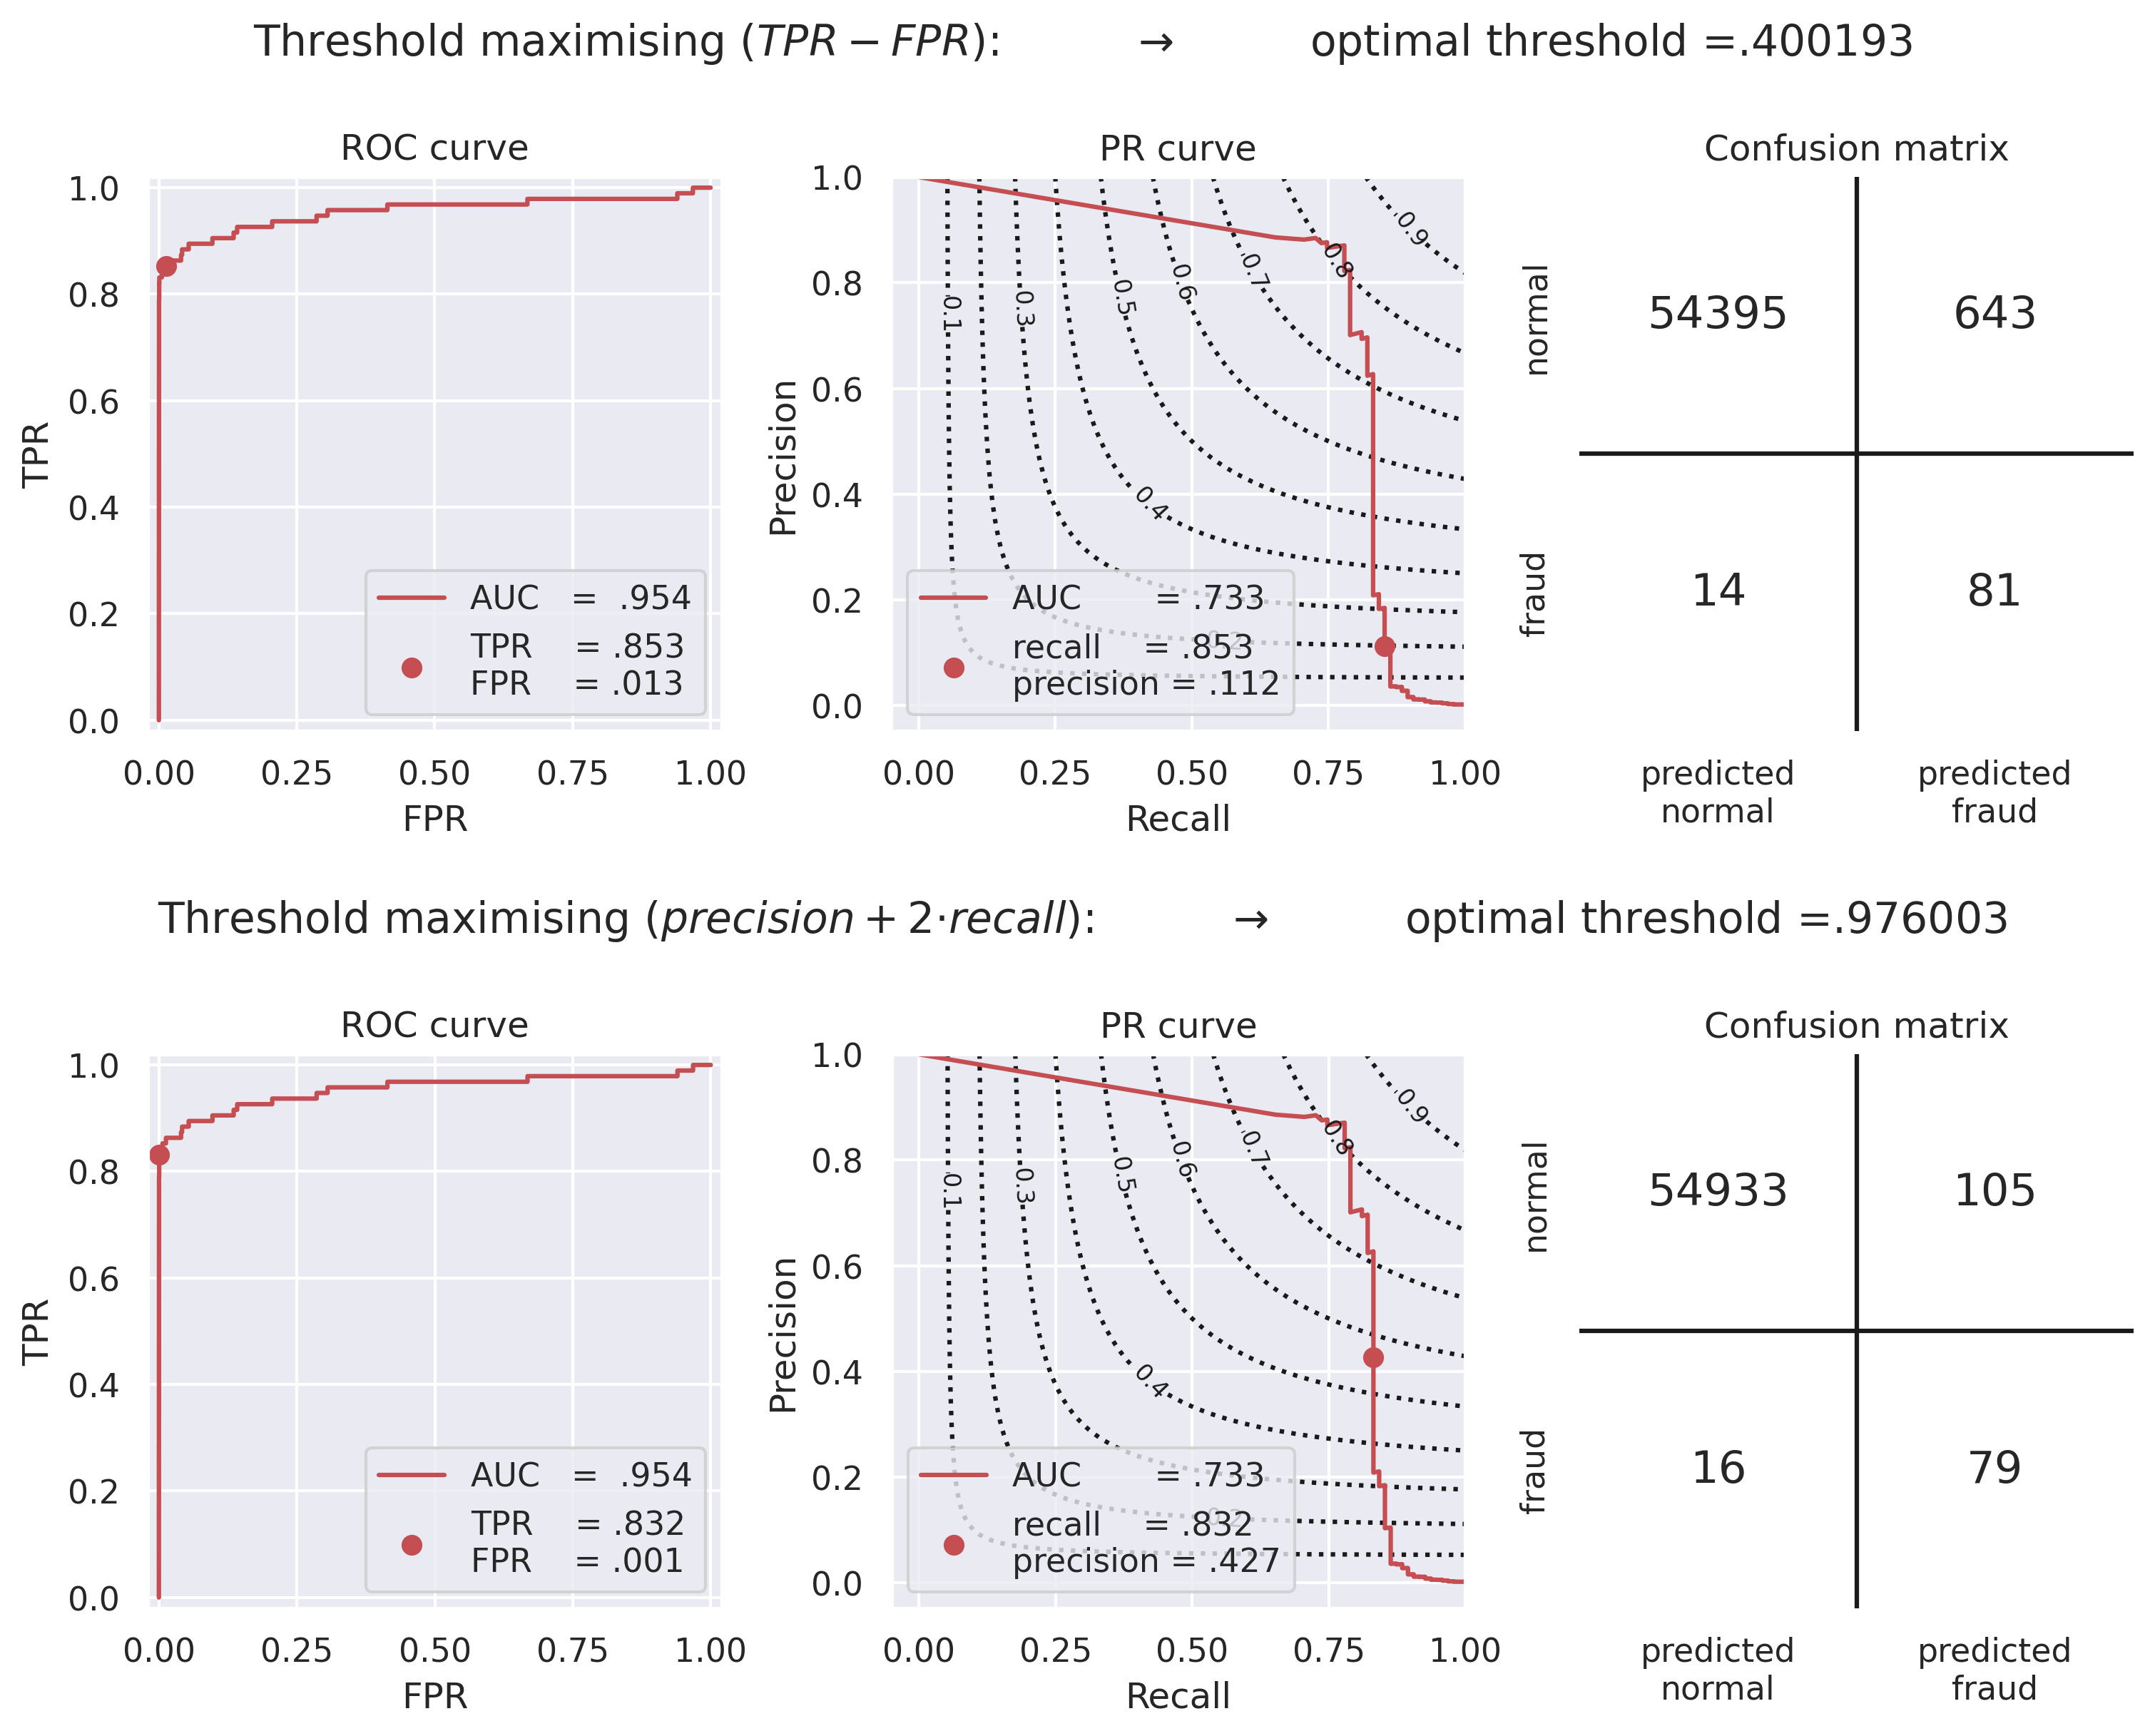

In [16]:
fig = plt.figure(layout='constrained', figsize=(10, 8), dpi=300)
subfigs = fig.subfigures(2, 1, hspace=0.05)

# =============================================================================
# finding optimal classifier threshold using train set (data leak prevention)
predicted_prob = best_NN.predict_proba(X_train)[:, 1]

fpr, tpr, thresholds = roc_curve(y_train, predicted_prob)
optim_thresh = thresholds[np.argmax(tpr - fpr)]

sns.set_theme(style='darkgrid')

predicted_prob = best_NN.predict_proba(X_test)[:, 1]


print(' ', '='*80, '\n', ' '*15, f'ROC threshold = {optim_thresh}\n', '='*80)
# Convert predictions to 0/1 labels
predicted_labels = np.array(predicted_prob >= optim_thresh).astype(int)

# Calculate accuracy on the test set
accuracy = accuracy_score(y_test, predicted_labels)
conf_matr = confusion_matrix(y_test, predicted_labels)
conf_matr = pd.DataFrame(conf_matr,
                         columns=['predicted\nnormal', 'predicted\nfraud'],
                         index=['normal', 'fraud'])
clas_rep = classification_report(y_test, predicted_labels)
print(f'Accuracy on the test set: {accuracy * 100:.3f}%\n'
      f'Class report:\n    {clas_rep}')

# ROC and PRC curves

axs1 = subfigs[0].subplots(1, 3)
subfigs[0].suptitle('Threshold maximising $(TPR - FPR)$:' +
                    ' '*10 + '→' + ' '*10 +
                    'optimal threshold =' + f'{optim_thresh:.6f}\n'.strip('0'))
axs1[0].set_title('ROC curve')
# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, predicted_prob)
auc = roc_auc_score(y_test, predicted_prob)
axs1[0].plot(fpr, tpr, 'r', label='AUC   =  '+f'{auc:.3f}'.strip('0'))
# optim_thresh
thr_idx = np.argmin(np.abs(thresholds - optim_thresh))
axs1[0].plot(fpr[thr_idx], tpr[thr_idx], 'ro', markersize=6,
             label='TPR    = '+f'{tpr[thr_idx]:.3f}\n'.strip('0') +
                   'FPR    = '+f'{fpr[thr_idx]:.3f}'.strip('0')
             )
# visuals
axs1[0].legend(loc='lower right')
axs1[0].set_xlabel('FPR')
axs1[0].set_ylabel('TPR')

# precision recall curve
# f1 score contours
array_0_1 = np.linspace(0.01, 1, 100)
f1_grid = np.empty((100, 100))
for i, a in enumerate(array_0_1):
    for ii, b in enumerate(array_0_1):
        f1_grid[i, ii] = 2*a*b/(a+b)
grid = np.meshgrid(array_0_1, array_0_1)
f1_score = axs1[1].contour(grid[0], grid[1], f1_grid,
                           levels=np.arange(0, 1, 0.1),
                           linestyles='dotted', colors='k')
axs1[1].clabel(f1_score, inline=True, fontsize=8)
del array_0_1, i, a, ii, b, f1_grid
# PRC
axs1[1].set_title('PR curve')
prec, rec, thresholds = precision_recall_curve(y_test, predicted_prob)
auc = average_precision_score(y_test, predicted_prob)
axs1[1].plot(rec, prec, 'r',
             label='AUC       = '+f'{auc:.3f}'.strip('0'))
# optim thresh
thr_idx = np.argmin(np.abs(thresholds - optim_thresh))
axs1[1].plot(rec[thr_idx], prec[thr_idx], 'ro', markersize=6,
             label='recall    = '+f'{rec[thr_idx]:.3f}\n'.strip('0') +
                   'precision = '+f'{prec[thr_idx]:.3f}'.strip('0'))
# visuals
axs1[1].set_xlabel('Recall')
axs1[1].set_ylabel('Precision')
axs1[1].legend(loc='lower left')

# plot confusion matrix
axs1[2].set_title('Confusion matrix')
sns.heatmap(conf_matr, cmap=['w'],
            ax=axs1[2], cbar=False, square=True,
            annot=True, fmt='.0f', annot_kws={'fontsize': 15})
axs1[2].vlines(1, 0, 2, 'k')
axs1[2].hlines(1, 0, 2, 'k')


for ax in axs1[0:1].flat:
    ax.set_xlim(-0.02, 1.02)
    ax.set_ylim(-0.02, 1.02)


# =============================================================================
# optimal threshold from PRC
# =============================================================================
# finding optimal classifier threshold using train set (data leak prevention)
predicted_prob = best_NN.predict_proba(X_train)[:, 1]

prec, rec, thresholds = precision_recall_curve(y_train, predicted_prob)
optim_thresh = thresholds[np.argmax(prec + coef*rec)]

sns.set_theme(style='darkgrid')

predicted_prob = best_NN.predict_proba(X_test)[:, 1]


print(' ', '='*80, '\n', ' '*15, f'PRC threshold = {optim_thresh}\n', '='*80)
# Convert predictions to 0/1 labels
predicted_labels = np.array(predicted_prob >= optim_thresh).astype(int)

# Calculate accuracy on the test set
accuracy = accuracy_score(y_test, predicted_labels)
conf_matr = confusion_matrix(y_test, predicted_labels)
conf_matr = pd.DataFrame(conf_matr,
                         columns=['predicted\nnormal', 'predicted\nfraud'],
                         index=['normal', 'fraud'])
clas_rep = classification_report(y_test, predicted_labels)
print(f'Accuracy on the test set: {accuracy * 100:.3f}%\n'
      f'Class report:\n    {clas_rep}')

# ROC and PRC curves
axs2 = subfigs[1].subplots(1, 3)
subfigs[1].suptitle(f'Threshold maximising $(precision + {coef}⋅recall)$:' +
                    ' '*10 + '→' + ' '*10 +
                    'optimal threshold ='+f'{optim_thresh:.6f}\n'.strip('0'))
axs2[0].set_title('ROC curve')
# 2ROC curve
fpr, tpr, thresholds = roc_curve(y_test, predicted_prob)
auc = roc_auc_score(y_test, predicted_prob)
axs2[0].plot(fpr, tpr, 'r', label='AUC   =  '+f'{auc:.3f}'.strip('0'))
# optim_thresh
thr_idx = np.argmin(np.abs(thresholds - optim_thresh))
axs2[0].plot(fpr[thr_idx], tpr[thr_idx], 'ro', markersize=6,
             label='TPR    = '+f'{tpr[thr_idx]:.3f}\n'.strip('0') +
                   'FPR    = '+f'{fpr[thr_idx]:.3f}'.strip('0')
             )
# visuals
axs2[0].legend(loc='lower right')
axs2[0].set_xlabel('FPR')
axs2[0].set_ylabel('TPR')

# precision recall curve
# f1 score contours
array_0_1 = np.linspace(0.01, 1, 100)
f1_grid = np.empty((100, 100))
for i, a in enumerate(array_0_1):
    for ii, b in enumerate(array_0_1):
        f1_grid[i, ii] = 2*a*b/(a+b)
grid = np.meshgrid(array_0_1, array_0_1)
f1_score = axs2[1].contour(grid[0], grid[1], f1_grid,
                           levels=np.arange(0, 1, 0.1),
                           linestyles='dotted', colors='k')
axs2[1].clabel(f1_score, inline=True, fontsize=8)
del array_0_1, i, a, ii, b, f1_grid
# PRC
axs2[1].set_title('PR curve')
prec, rec, thresholds = precision_recall_curve(y_test, predicted_prob)
auc = average_precision_score(y_test, predicted_prob)
axs2[1].plot(rec, prec, 'r',
             label='AUC       = '+f'{auc:.3f}'.strip('0'))
# optim thresh
thr_idx = np.argmin(np.abs(thresholds - optim_thresh))
axs2[1].plot(rec[thr_idx], prec[thr_idx], 'ro', markersize=6,
             label='recall    = '+f'{rec[thr_idx]:.3f}\n'.strip('0') +
                   'precision = '+f'{prec[thr_idx]:.3f}'.strip('0'))
# visuals
axs2[1].set_xlabel('Recall')
axs2[1].set_ylabel('Precision')
axs2[1].legend(loc='lower left')

# plot confusion matrix
axs2[2].set_title('Confusion matrix')
sns.heatmap(conf_matr, cmap=['w'],
            ax=axs2[2], cbar=False, square=True,
            annot=True, fmt='.0f', annot_kws={'fontsize': 15})
axs2[2].vlines(1, 0, 2, 'k')
axs2[2].hlines(1, 0, 2, 'k')

for ax in axs2[0:1].flat:
    ax.set_xlim(-0.02, 1.02)
    ax.set_ylim(-0.02, 1.02)

# plt.tight_layout()
plt.show()
plt.close()

# Conclusion

Comparing results of this network to the original draft, we have not gained much. Although, we have to note here, that the results of the original draft were influenced by using the test set for validation.

We can see that with a reasonable threshold, our neural network can achieve quite reasonable balance between very high recall with fairly reasonable precision. Unless we develop a perfect model (we could play around with this one a bit more, creating a pipeline and trying various oversampling/undersampling methods), the model for final deployment is always going to be a **business decision**:
* What are the costs associated with having slighlty more undetected fraudulent transactions?
* What are the costs associated with freezing a genuine transaction?
* How expensive is it for a human expert to inspect transactions flagged as fraudulant? Are ten quick checks of such transaction outweighted by one undetected fraud? How about a hundred quick checks?

In the end, even though playing with data for fun is great, what matters is what can your model provide to reality.